In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !git clone https://github.com/wm0395/LLM_Project.git
# !ls /kaggle/working/
# !mv /kaggle/working/LLM_Project/CONAN-master /kaggle/working/CONAN-master
# !mv /kaggle/working/LLM_Project/rome-main /kaggle/working/rome-main
# !pip install -r /kaggle/working/rome-main/scripts/colab_reqs/rome.txt >> install.log 2>&1
# !pip install --upgrade google-cloud-storage >> install.log 2>&1
# !cd /kaggle/working/rome_main

In [11]:
import os, re, json
import torch, numpy
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

IS_COLAB = True
torch.set_grad_enabled(False)

In [12]:
model_name = "tum-nlp/gpt-2-medium-target-aware-counterspeech-generation" # or "gpt2-xl" or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

tokenizer_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

In [13]:
predict_token(
    mt,
    ["Megan Rapinoe plays the sport of", "The Space Needle is in the city of"],
    return_p=True,
)

([' football', ' Birmingham'], tensor([0.2158, 0.9517], device='cuda:0'))

In [14]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

Loaded dataset with 1209 elements
Using noise level 0.32325466722249985


# Token Generation

In [15]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

In [16]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

In [24]:
def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    with plt.rc_context(rc={"font.family": "Times New Roman"}):
        # Adjust the figure size for better readability
        fig, ax = plt.subplots(figsize=(8, 6), dpi=200)  # Larger dimensions

        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)), fontsize=10)  # Larger font size
        ax.set_yticklabels(labels, fontsize=10)  # Larger font size

        if not modelname:
            modelname = "GPT"
        if not kind:
            ax.set_title(
                "Impact of restoring state after corrupted input",
                fontsize=12  # Larger title font size
            )
            ax.set_xlabel(f"single restored layer within {modelname}", fontsize=10)
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(
                f"Impact of restoring {kindname} after corrupted input",
                fontsize=12  # Larger title font size
            )
            ax.set_xlabel(
                f"center of interval of {window} restored {kindname} layers",
                fontsize=10
            )
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title, fontsize=12)
        if xlabel is not None:
            ax.set_xlabel(xlabel, fontsize=10)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(
                f"p({str(answer).strip()})", y=-0.16, fontsize=10
            )  # Increased font size
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()
            
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf="/kaggle/working/pdfs/",
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

In [25]:
KN_PROMPT_TEMPLATE = """You are an expert counterspeech generator, you will also be provided some extra knowledge to refer to while generating counterspeech. Here are some examples of how to generate counterspeech.
    Hate Speech: I'm tired of woman taking part to political debate. Feminism is a divisive force in society.
    Extra Knowledge: Women openly claiming feminism and a desire for equality?I keep trying to imagine a universe in which too many public figures declaring themselves feminists would be a bad thing.In this universe, where women would be free to simply live their lives, “feminist” would become an antiquated term.Perhaps they thought it reasonable to once again make feminism, and in turn the concerns of women, a sacrificial lamb.It’s an amusing idea to some, this feminism thing — this audacious notion that women should be able to move through the world as freely, and enjoy the same inalienable rights and bodily autonomy, as men.To include “feminist” in this poll was irresponsible and lazy.
    Counter Speech: Yeah, it’s an amusing idea to some, this feminism thing — this audacious notion that women should be able to move through the world as freely, and enjoy the same inalienable rights and bodily autonomy, as men.

    Hate Speech: Some races are poor because they are inferior, also in the eye of the Lord.
    Extra Knowledge: Young people, and even adults, often wonder how all the varieties or ""races"" of people could come from the same original human ancestors. The Bible clearly teaches that God created all human beings in His image. Just as some individuals today carry genes to produce descendants with different color hair and eyes, humanity's first parents, Adam and Eve, possessed genes to produce all the variety and races of men. Thus, both will have different abilities to affect the eye color of their offspring. Of course not! You and I today may not carry the genes to produce every variety or race of humans, but humanity's first parents did possess such genes.
    Counter Speech: The Bible clearly teaches that God created all human beings in His image.
    
    Hate Speech: {hate_speech}
    Extra Knowledge: {kn_info}
    Counter-speech: {counter_speech}
    """

hate_speech = "Why gays do not try to heal?"
kn_info = "We must always consider the person. it is not possible to interfere spiritually in the life of a person.” In life, God accompanies persons, and we must accompany them, starting from their situation. A person once asked me, in a provocative manner, if I approved of homosexuality. “The Jesuit must be a person whose thought is incomplete, in the sense of open-ended thinking,” he said. I said that if a homosexual person is of good will and is in search of God, I am no one to judge."
counter_speech = "Homosexuality is not a disease. It is a sexual orientation. "

prompt = KN_PROMPT_TEMPLATE.format(hate_speech=hate_speech, kn_info=kn_info, counter_speech=counter_speech)

In [ ]:
plot_all_flow(mt, prompt, noise=noise_level)

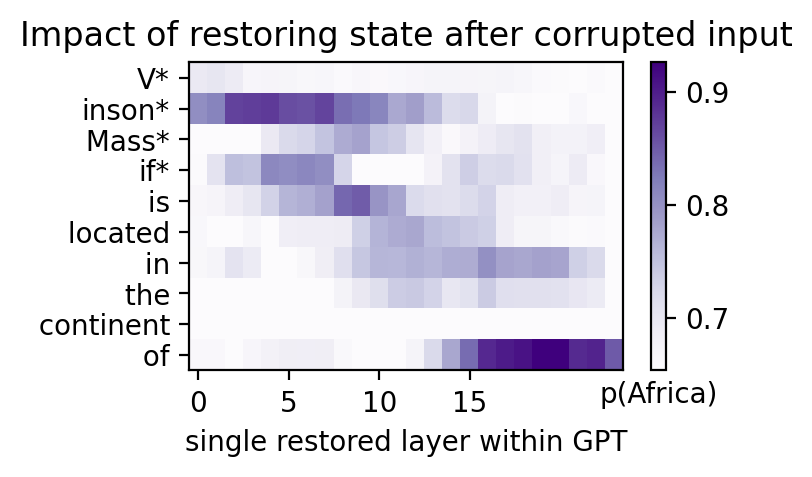

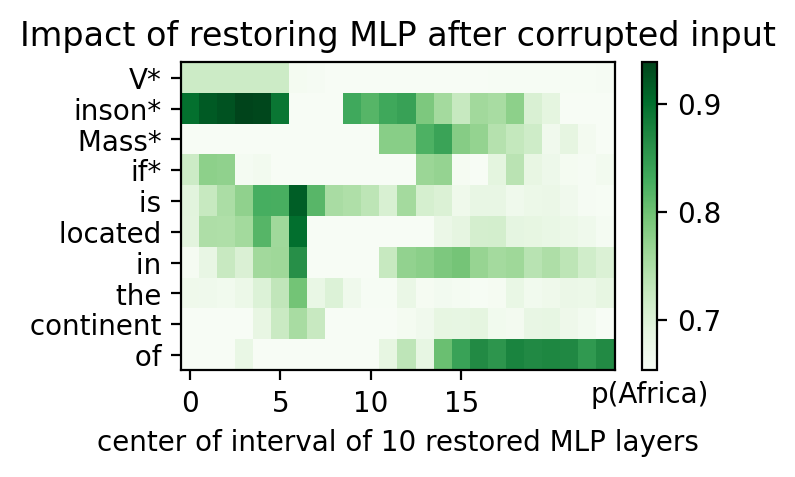

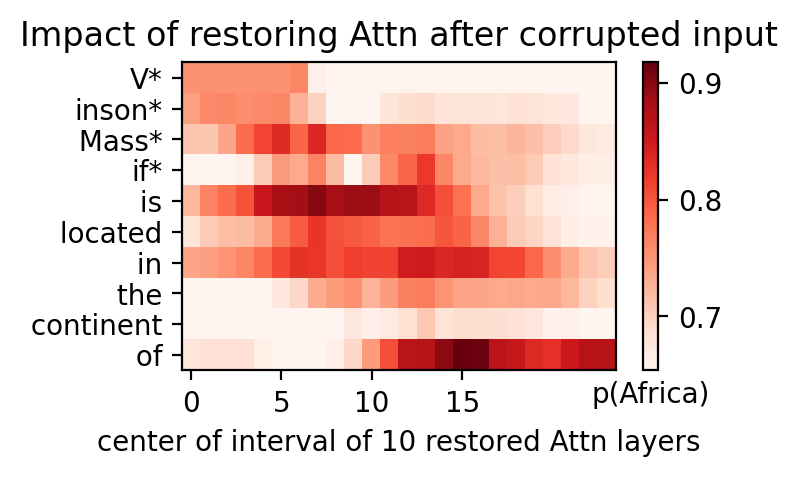

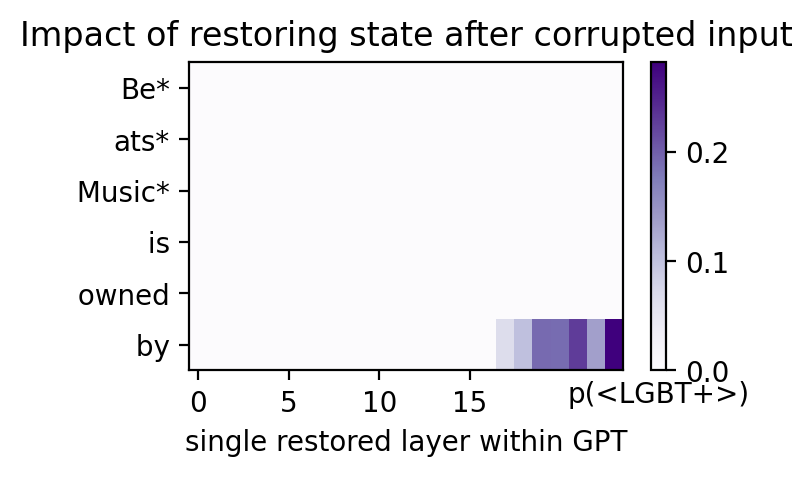

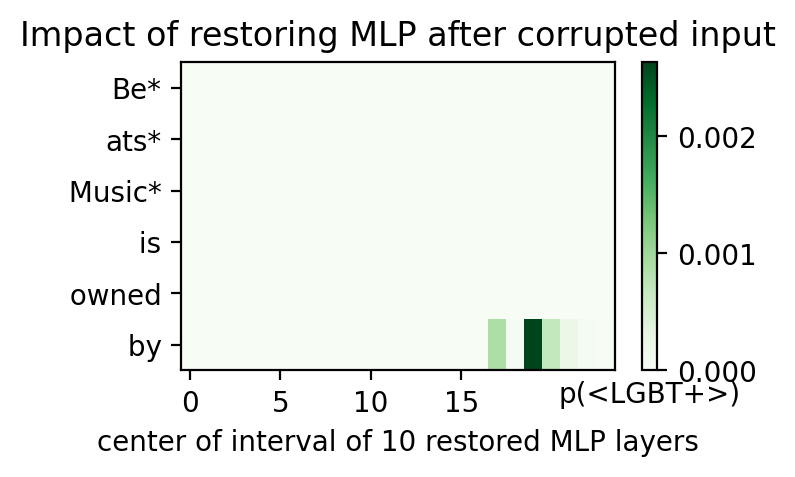

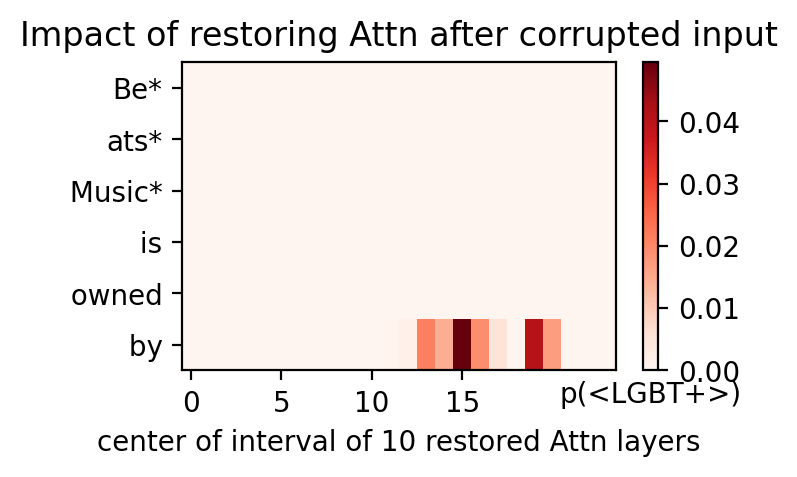

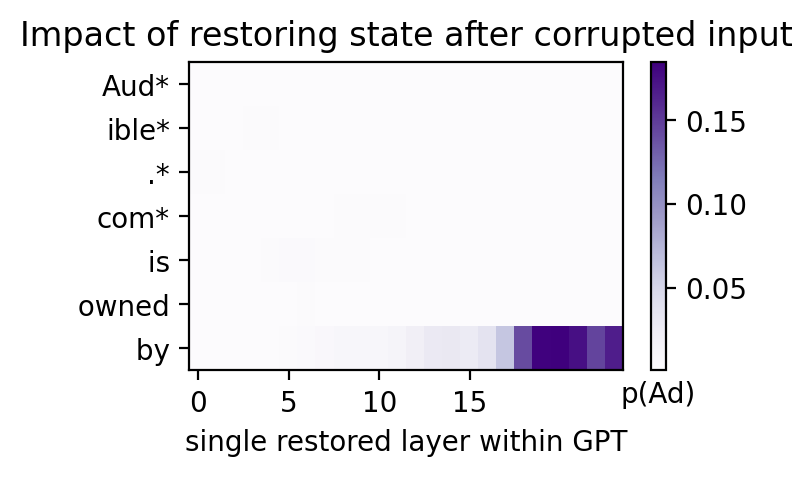

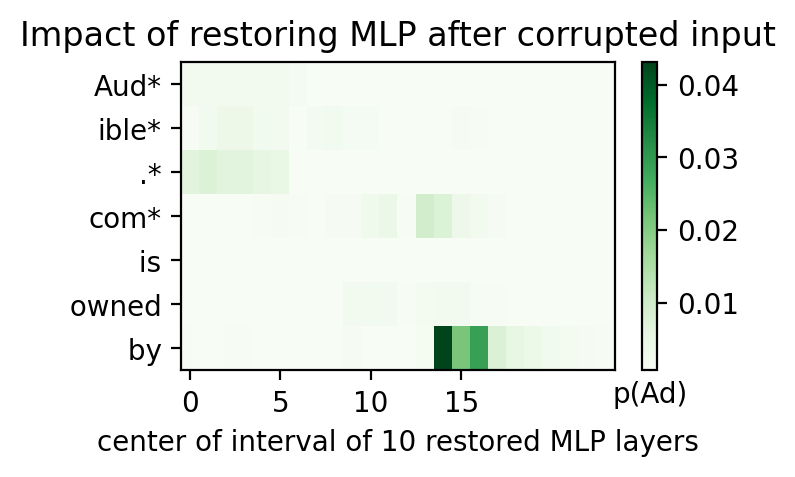

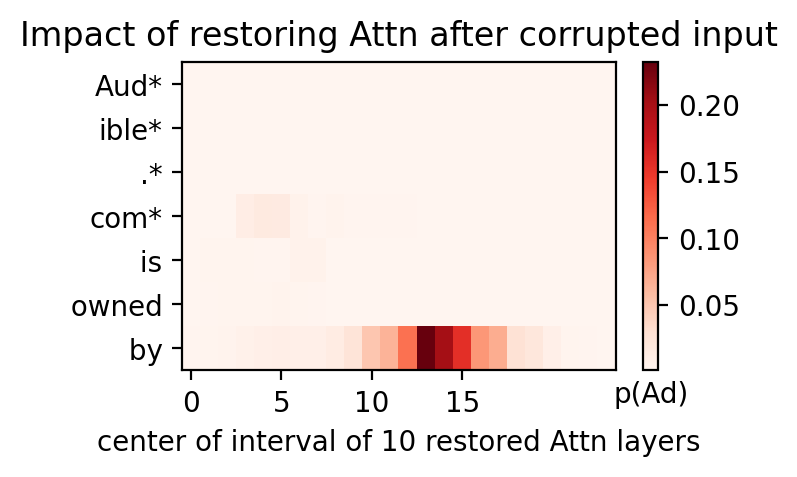

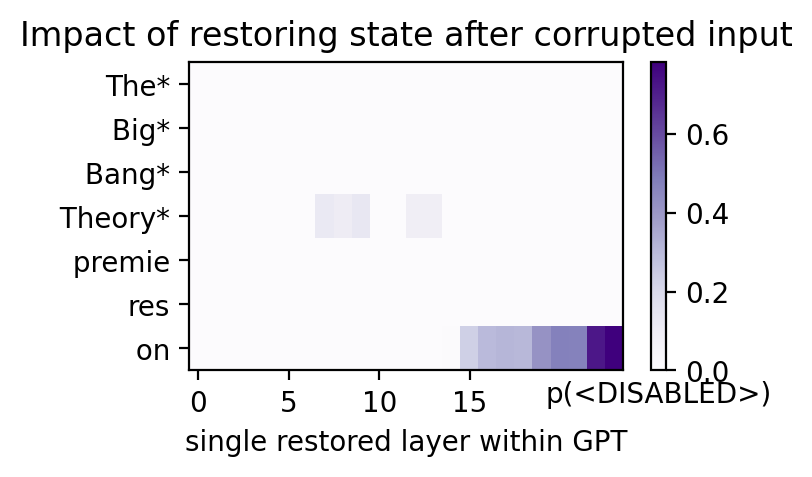

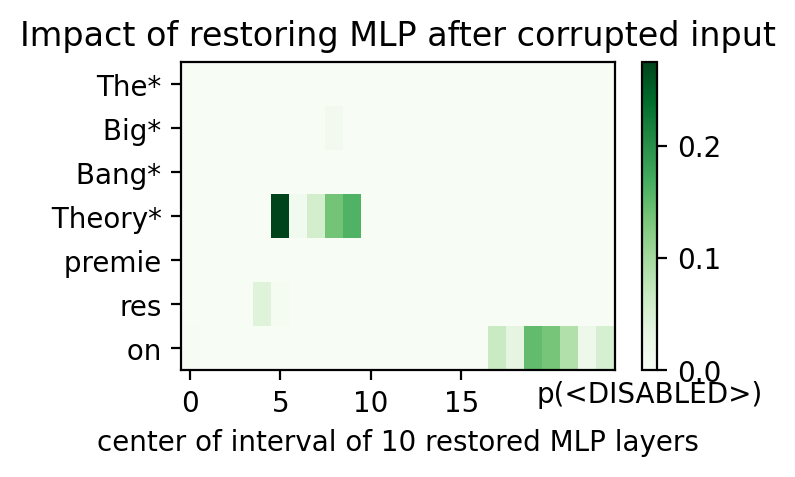

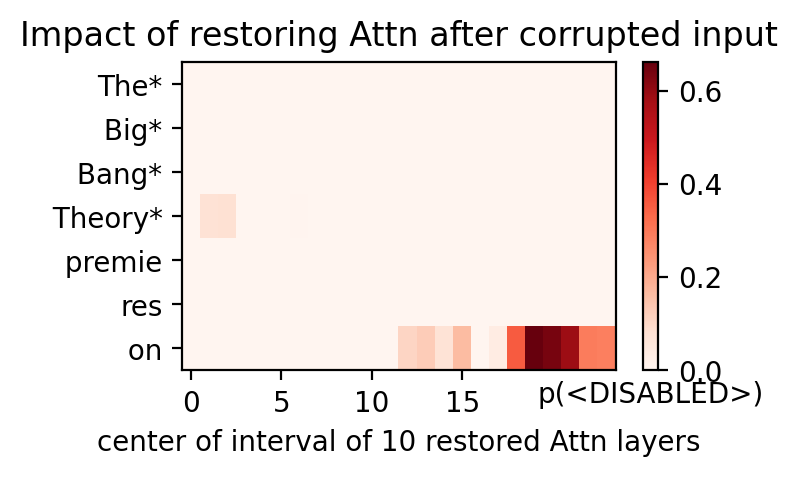

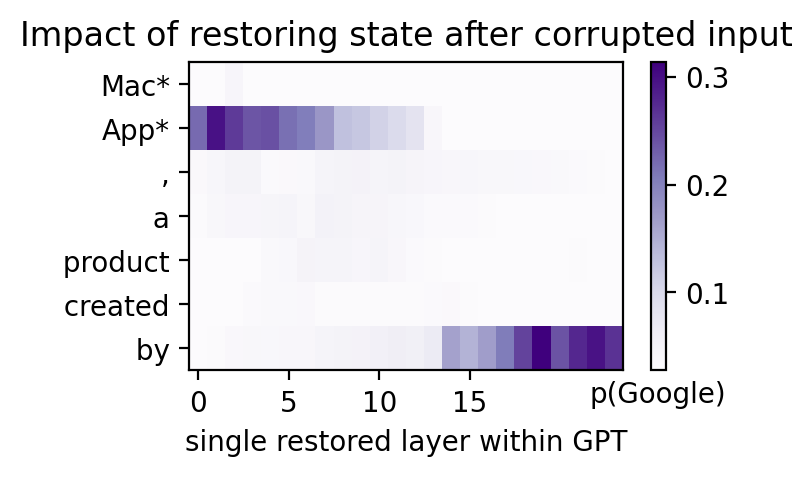

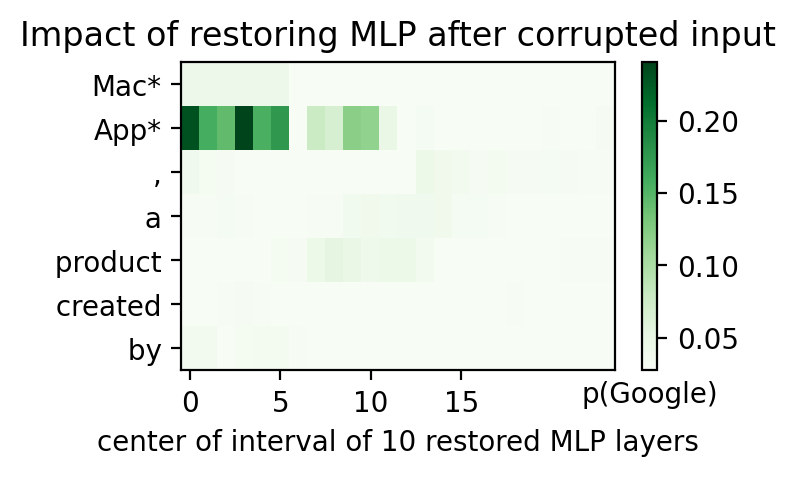

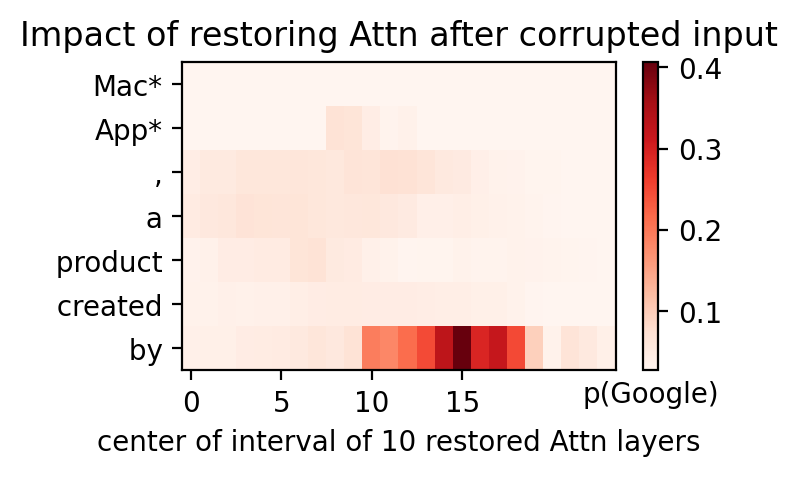

In [44]:
for knowledge in knowns[:5]:
    plot_all_flow(mt, knowledge["prompt"], knowledge["subject"], noise=noise_level)

In [14]:
pip install transformers nltk rouge-score sacrebleu requests

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=19f31fe589ffd147e89f3b38efa6f4b409c8c9ccf40ed33aadc800a2b163f076
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [86]:
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import requests

# Load Model and Tokenizer
model_name = "tum-nlp/gpt-2-medium-target-aware-counterspeech-generation"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
api_key = "fc607a0ed5a44a2faca3440d70b48351"  # Replace with actual API key

# Function to Generate Counterspeech
def generate_counterspeech(prompt, max_length=300):
    """
    Generate concise counterspeech based on a given prompt.
    """
    input_data = tokenizer(prompt, return_tensors="pt", padding=True)
    output_sequences = model.generate(
        input_ids=input_data['input_ids'].to(model.device),
        attention_mask=input_data['attention_mask'].to(model.device),
        pad_token_id=tokenizer.eos_token_id,
        max_length=max_length,  # Reduce maximum length for concise output
        num_beams=5,
        no_repeat_ngram_size=3,
        num_return_sequences=1,
        early_stopping=True,
        length_penalty=2.4,  # Penalize longer outputs
    )
    generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    
    # Extract only the counter-speech part (after "Counter-speech: ")
    counter_speech = generated_text.split("Counter-speech:")[-1].strip()
    return counter_speech

# Metrics Calculation
def calculate_metrics(predicted, ground_truth):
    """
    Calculate evaluation metrics for predicted counterspeech against the ground truth.
    """
    metrics = {}

    # Exact Match
    metrics['exact_match'] = int(predicted.strip() == ground_truth.strip())

    # BLEU Score
    smoothing = SmoothingFunction().method1
    metrics['bleu'] = sentence_bleu([ground_truth.split()], predicted.split(), smoothing_function=smoothing)

    # ROUGE Score
    rouge = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = rouge.score(ground_truth, predicted)
    metrics['rouge'] = {key: rouge_scores[key].fmeasure for key in rouge_scores}

    return metrics

def check_factuality_with_claimbuster(statement):
    """
    Check the factuality of a statement using ClaimBuster API.
    
    Args:
    - statement (str): The statement to be fact-checked.
    - api_key (str): The API key to authenticate with ClaimBuster.

    Returns:
    - float: The factuality score between 0 and 1.
    """
    # Define the API endpoint and headers
    api_endpoint = "https://idir.uta.edu/claimbuster/api/v2/score/text/"
    request_headers = {"x-api-key": api_key}
    
    # Prepare the payload (the text to be fact-checked)
    payload = {"input_text": statement}
    
    # Send POST request to ClaimBuster API
    api_response = requests.post(url=api_endpoint, json=payload, headers=request_headers)
    
    # Check if the response is valid
    if api_response.status_code == 200:
        # Parse the JSON response from the API
        response_json = api_response.json()
        # Extract and return the factuality score
        return response_json.get("score", 0)
    else:
        # Print error message if API request fails
        print(f"Error: {api_response.status_code}, {api_response.text}")
        return None

# Evaluate Model Outputs
def evaluate_model(prompts, ground_truths):
    """
    Evaluate the model's outputs for given prompts and ground truths.
    """
    results = []
    for prompt, ground_truth in zip(prompts, ground_truths):
        # Generate counterspeech
        predicted = generate_counterspeech(prompt)
        
        # Calculate metrics
        metrics = calculate_metrics(predicted, ground_truth)
        metrics['prompt'] = prompt
        metrics['ground_truth'] = ground_truth
        metrics['predicted'] = predicted

        # Identify poor-performing examples and check factuality
        if metrics['bleu'] < 0.5 or metrics['exact_match'] == 0:
            metrics['claimbuster_score'] = check_factuality_with_claimbuster(predicted)
        
        results.append(metrics)
    return results


# Sequence Generation

In [42]:
def trace_with_patch_sequence(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    max_length=100,  # Maximum length of the sequence to generate
    noise=0.1,  # Level of noise to add
    uniform_noise=False,  # Whether to use uniform noise instead of normal
    replace=False,  # True to replace with instead of add noise
):
    """
    Traces and generates entire sequences, comparing corrupted, patched, and uncorrupted runs.
    """
    # Random state for reproducibility
    rs = np.random.RandomState(1)
    if uniform_noise:
        def prng(*shape):
            return rs.uniform(-1, 1, shape)
    else:
        def prng(*shape):
            return rs.randn(*shape)

    # Prepare the patch specification
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)

    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        """Unwraps a tuple if necessary."""
        return x[0] if isinstance(x, tuple) else x

    def patch_rep(x, layer):
        if layer == embed_layername:
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                noise_data = (
                    noise * torch.from_numpy(prng(x.shape[0] - 1, e - b, x.shape[2]))
                ).to(x.device)
                if replace:
                    x[1:, b:e] = noise_data  # No slicing along batch dimension
                else:
                    x[1:, b:e] += noise_data
            return x
        
        if layer not in patch_spec:
            return x
    
        # Patch specific tokens
        h = untuple(x)
        if h.shape[1] > 1:  # Ensure batch size > 1 before slicing
            for t in patch_spec[layer]:
                h[1:, t] = h[0, t]  # Restore token representation from the first batch
        else:
            # For batch size = 1, apply the patch only to the available batch
            for t in patch_spec[layer]:
                h[:, t] = h[0, t]  # Modify only the available batch
        return x



    # Run the patched model
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()),
        edit_output=patch_rep,
    ):
        generated_sequences = model.generate(
            input_ids=inp["input_ids"],
            attention_mask=inp.get("attention_mask"),
            max_length=max_length,
            do_sample=False,
            num_beams=5,
            no_repeat_ngram_size=3,
            num_return_sequences=1,
            early_stopping=True,
            length_penalty=2.4,
        )

    return generated_sequences

def trace_with_repatch_sequence(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    states_to_unpatch,  # A list of (token index, layername) triples to re-randomize
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    max_length,  # Maximum length of the sequence to generate
    noise=0.1,  # Level of noise to add
    uniform_noise=False,
):
    rs = numpy.random.RandomState(1)
    prng = (
        lambda *shape: rs.uniform(-1, 1, shape)
        if uniform_noise
        else lambda *shape: rs.randn(*shape)
    )
    patch_spec = defaultdict(list)
    unpatch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    for t, l in states_to_unpatch:
        unpatch_spec[l].append(t)

    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    def patch_rep(x, layer):
        if layer == embed_layername:
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if first_pass or (layer not in patch_spec and layer not in unpatch_spec):
            return x
        h = untuple(x)
        for t in patch_spec.get(layer, []):
            h[1:, t] = h[0, t]
        for t in unpatch_spec.get(layer, []):
            h[1:, t] = untuple(first_pass_trace[layer].output)[1:, t]
        return x

    for first_pass in [True, False] if states_to_unpatch else [False]:
        with torch.no_grad(), nethook.TraceDict(
            model,
            [embed_layername] + list(patch_spec.keys()) + list(unpatch_spec.keys()),
            edit_output=patch_rep,
        ) as td:
            outputs_exp = model(**inp)
            if first_pass:
                first_pass_trace = td

    # Generate sequences after patching
    with torch.no_grad():
        generated_sequences = model.generate(
            input_ids=inp["input_ids"],
            attention_mask=inp.get("attention_mask"),
            max_length=max_length,
            num_return_sequences=inp["input_ids"].shape[0],
            do_sample=False,
        )

    return generated_sequences

def compute_metrics(reference, hypothesis):
    """
    Compute BLEU and Rouge metrics for given sequences.
    """
    bleu = sentence_bleu([reference.split()], hypothesis.split())
    scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)
    rouge = scorer.score(reference, hypothesis)
    return {"BLEU": bleu, "ROUGE-1": rouge["rouge1"].fmeasure, "ROUGE-L": rouge["rougeL"].fmeasure}

def calculate_hidden_flow(
    mt,
    prompt,
    subject,
    samples=10,
    noise=0.1,
    token_range=None,
    uniform_noise=False,
    replace=False,
    window=10,
    kind=None,
    expect=None,
):
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        uncorrupted_output = mt.model.generate(**inp, max_length=50)
    uncorrupted_text = decode_tokens(mt.tokenizer, uncorrupted_output)

    sequences = trace_important_states(
        mt.model,
        mt.num_layers,
        inp,
        find_token_range(mt.tokenizer, inp["input_ids"][0], subject),
        noise=noise,
        uniform_noise=uniform_noise,
        replace=replace,
        token_range=range(inp["input_ids"].shape[1]),
    )

    metrics = [
        compute_metrics(uncorrupted_text, decode_tokens(mt.tokenizer, seq))
        for seq in sequences
    ]
    return metrics

def trace_important_states(
    model,
    num_layers,
    inp,
    e_range,
    noise=0.1,
    uniform_noise=False,
    replace=False,
    token_range=None,
):
    ntoks = inp["input_ids"].shape[1]
    sequences = []

    if token_range is None:
        token_range = range(ntoks)
    for tnum in token_range:
        for layer in range(num_layers):
            outputs = trace_with_patch_sequence(
                model,
                inp,
                [(tnum, layername(model, layer))],
                tokens_to_mix=e_range,
                noise=noise,
                uniform_noise=uniform_noise,
                replace=replace,
            )
            sequences.append(outputs)
    return sequences


def trace_important_window(
    model,
    num_layers,
    inp,
    e_range,
    window=10,
    noise=0.1,
    uniform_noise=False,
    replace=False,
    token_range=None,
):
    ntoks = inp["input_ids"].shape[1]
    sequences = []

    if token_range is None:
        token_range = range(ntoks)
    for tnum in token_range:
        for layer in range(num_layers):
            layerlist = [
                (tnum, layername(model, L))
                for L in range(max(0, layer - window // 2), min(num_layers, layer + window // 2))
            ]
            outputs = trace_with_patch_sequence(
                model,
                inp,
                layerlist,
                tokens_to_mix=e_range,
                noise=noise,
                uniform_noise=uniform_noise,
                replace=replace,
            )
            sequences.append(outputs)
    return sequences

class ModelAndTokenizer:
    """
    An object to hold on to (or automatically download and hold)
    a GPT-style language model and tokenizer.  Counts the number
    of layers.
    """

    def __init__(
        self,
        model_name=None,
        model=None,
        tokenizer=None,
        low_cpu_mem_usage=False,
        torch_dtype=None,
    ):
        if tokenizer is None:
            assert model_name is not None
            tokenizer = AutoTokenizer.from_pretrained(model_name)
        if model is None:
            assert model_name is not None
            model = AutoModelForCausalLM.from_pretrained(
                model_name, low_cpu_mem_usage=low_cpu_mem_usage, torch_dtype=torch_dtype
            )
            nethook.set_requires_grad(False, model)
            model.eval().cuda()
        self.tokenizer = tokenizer
        self.model = model
        self.layer_names = [
            n
            for n, m in model.named_modules()
            if (re.match(r"^(transformer|gpt_neox)\.(h|layers)\.\d+$", n))
        ]
        self.num_layers = len(self.layer_names)

    def __repr__(self):
        return (
            f"ModelAndTokenizer(model: {type(self.model).__name__} "
            f"[{self.num_layers} layers], "
            f"tokenizer: {type(self.tokenizer).__name__})"
        )


def layername(model, num, kind=None):
    if hasattr(model, "transformer"):
        if kind == "embed":
            return "transformer.wte"
        return f'transformer.h.{num}{"" if kind is None else "." + kind}'
    if hasattr(model, "gpt_neox"):
        if kind == "embed":
            return "gpt_neox.embed_in"
        if kind == "attn":
            kind = "attention"
        return f'gpt_neox.layers.{num}{"" if kind is None else "." + kind}'
    assert False, "unknown transformer structure"


def guess_subject(prompt):
    return re.search(r"(?!Wh(o|at|ere|en|ich|y) )([A-Z]\S*)(\s[A-Z][a-z']*)*", prompt)[
        0
    ].strip()


def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    uniform_noise=False,
    window=10,
    kind=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt,
        prompt,
        subject,
        samples=samples,
        noise=noise,
        uniform_noise=uniform_noise,
        window=window,
        kind=kind,
    )
    plot_trace_heatmap(result, savepdf)


def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    with plt.rc_context(rc={"font.family": "Times New Roman"}):
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels)
        if not modelname:
            modelname = "GPT"
        if not kind:
            ax.set_title("Impact of restoring state after corrupted input")
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(f"Impact of restoring {kindname} after corrupted input")
            ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()


def plot_all_flow(mt, prompt, subject=None):
    for kind in ["mlp", "attn", None]:
        plot_hidden_flow(mt, prompt, subject, kind=kind)


# Utilities for dealing with tokens
def make_inputs(tokenizer, prompts, device="cuda"):
    token_lists = [tokenizer.encode(p) for p in prompts]
    maxlen = max(len(t) for t in token_lists)
    if "[PAD]" in tokenizer.all_special_tokens:
        pad_id = tokenizer.all_special_ids[tokenizer.all_special_tokens.index("[PAD]")]
    else:
        pad_id = 0
    input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
    # position_ids = [[0] * (maxlen - len(t)) + list(range(len(t))) for t in token_lists]
    attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
    return dict(
        input_ids=torch.tensor(input_ids).to(device),
        #    position_ids=torch.tensor(position_ids).to(device),
        attention_mask=torch.tensor(attention_mask).to(device),
    )


def decode_tokens(tokenizer, token_array):
    if hasattr(token_array, "shape") and len(token_array.shape) > 1:
        return [decode_tokens(tokenizer, row) for row in token_array]
    return [tokenizer.decode([t]) for t in token_array]


def find_token_range(tokenizer, token_array, substring):
    toks = decode_tokens(tokenizer, token_array)
    whole_string = "".join(toks)
    char_loc = whole_string.index(substring)
    loc = 0
    tok_start, tok_end = None, None
    for i, t in enumerate(toks):
        loc += len(t)
        if tok_start is None and loc > char_loc:
            tok_start = i
        if tok_end is None and loc >= char_loc + len(substring):
            tok_end = i + 1
            break
    return (tok_start, tok_end)


def predict_token(mt, prompts, return_p=False):
    inp = make_inputs(mt.tokenizer, prompts)
    preds, p = predict_from_input(mt.model, inp)
    result = [mt.tokenizer.decode(c) for c in preds]
    if return_p:
        result = (result, p)
    return result


def predict_from_input(model, inp):
    out = model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    p, preds = torch.max(probs, dim=1)
    return preds, p


def collect_embedding_std(mt, subjects):
    alldata = []
    for s in subjects:
        inp = make_inputs(mt.tokenizer, [s])
        with nethook.Trace(mt.model, layername(mt.model, 0, "embed")) as t:
            mt.model(**inp)
            alldata.append(t.output[0])
    alldata = torch.cat(alldata)
    noise_level = alldata.std().item()
    return noise_level


def get_embedding_cov(mt):
    model = mt.model
    tokenizer = mt.tokenizer

    def get_ds():
        ds_name = "wikitext"
        raw_ds = load_dataset(
            ds_name,
            dict(wikitext="wikitext-103-raw-v1", wikipedia="20200501.en")[ds_name],
        )
        try:
            maxlen = model.config.n_positions
        except:
            maxlen = 100  # Hack due to missing setting in GPT2-NeoX.
        return TokenizedDataset(raw_ds["train"], tokenizer, maxlen=maxlen)

    ds = get_ds()
    sample_size = 1000
    batch_size = 5
    filename = None
    batch_tokens = 100

    progress = lambda x, **k: x

    stat = Covariance()
    loader = tally(
        stat,
        ds,
        cache=filename,
        sample_size=sample_size,
        batch_size=batch_size,
        collate_fn=length_collation(batch_tokens),
        pin_memory=True,
        random_sample=1,
        num_workers=0,
    )
    with torch.no_grad():
        for batch_group in loader:
            for batch in batch_group:
                batch = dict_to_(batch, "cuda")
                del batch["position_ids"]
                with nethook.Trace(model, layername(mt.model, 0, "embed")) as tr:
                    model(**batch)
                feats = flatten_masked_batch(tr.output, batch["attention_mask"])
                stat.add(feats.cpu().double())
    return stat.mean(), stat.covariance()


def make_generator_transform(mean=None, cov=None):
    d = len(mean) if mean is not None else len(cov)
    device = mean.device if mean is not None else cov.device
    layer = torch.nn.Linear(d, d, dtype=torch.double)
    nethook.set_requires_grad(False, layer)
    layer.to(device)
    layer.bias[...] = 0 if mean is None else mean
    if cov is None:
        layer.weight[...] = torch.eye(d).to(device)
    else:
        _, s, v = cov.svd()
        w = s.sqrt()[None, :] * v
        layer.weight[...] = w
    return layer


def collect_embedding_gaussian(mt):
    m, c = get_embedding_cov(mt)
    return make_generator_transform(m, c)


def collect_embedding_tdist(mt, degree=3):
    # We will sample sqrt(degree / u) * sample, where u is from the chi2[degree] dist.
    # And this will give us variance is (degree / degree - 2) * cov.
    # Therefore if we want to match the sample variance, we should
    # reduce cov by a factor of (degree - 2) / degree.
    # In other words we should be sampling sqrt(degree - 2 / u) * sample.
    u_sample = torch.from_numpy(
        numpy.random.RandomState(2).chisquare(df=degree, size=1000)
    )
    fixed_sample = ((degree - 2) / u_sample).sqrt()
    mvg = collect_embedding_gaussian(mt)

    def normal_to_student(x):
        gauss = mvg(x)
        size = gauss.shape[:-1].numel()
        factor = fixed_sample[:size].reshape(gauss.shape[:-1] + (1,))
        student = factor * gauss
        return student

    return normal_to_student

In [43]:
plot_all_flow(mt, "According to a recent OFSTED report, a school in Birmingham is still segregating girls and boys, despite a Hight Court ruling in 2017 that this is unlawful. Counterspeech: ")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

IndexError: index 1 is out of bounds for dimension 1 with size 1

# CounterSpeech Generation

In [106]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Model and Tokenizer
model_name = "tum-nlp/gpt-2-medium-target-aware-counterspeech-generation"
model = AutoModelForCausalLM.from_pretrained(model_name).to(torch_device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"

PROMPT_TEMPLATE = """You are an expert counterspeech generator. Here are some examples of how to generate counterspeech.
    Hate Speech: The vast majority of Muslims are unemployed and refuse to work.
    Counter Speech: David Pedulla, a sociologist at the University of Texas at Austin, sent out thousands of fake resumes to test how gender and work history affected callbacks by potential employers looking to interview the simulated job candidates. They found that the consequences of unemployment differ in important ways by the race and gender of the job applicant with significant discriminatory behaviour by potential employers. So, is really the vast majority of Muslims refusing to work or are they just being discriminated?

    Hate Speech: Some races have lower physical and cognitive abilities, the sooner we accept this, the better it will be for humanity.
    Counter Speech: The bankrupt concept of fixed and immutable human ""races"" — packages of physical and behavioral traits — ranked by color has led to the creation of potent and persistent racial stereotypes handed down to our days.
    
    Hate Speech: {hate_speech} 
    Counter-speech: 
    """

# Function to Generate Counterspeech
def generate_counterspeech(hate_speech, max_length=300):
    prompt = PROMPT_TEMPLATE.format(hate_speech=hate_speech)
    input_data = tokenizer(prompt, return_tensors="pt", padding=True)
    output_sequences = model.generate(
        input_ids=input_data['input_ids'].to(torch_device),
        attention_mask=input_data['attention_mask'].to(torch_device),
        pad_token_id=tokenizer.eos_token_id,
        max_length=max_length,
        num_beams=5,
        no_repeat_ngram_size=3,
        num_return_sequences=1,
        early_stopping=True,
        length_penalty=2.4,
    )
    generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    return generated_text.split("Counter-speech:")[-1].strip()

# Process CSV File with Sampling
def process_random_sample(input_csv, output_csv, sample_size=200):
    """
    Process a random sample of rows from the CONAN dataset, generate counterspeech, and save results.
    
    Args:
    - input_csv (str): Path to the input CONAN CSV file.
    - output_csv (str): Path to the output CSV file with appended results.
    - sample_size (int): Number of random samples to process.
    """
    # Load the dataset
    data = pd.read_csv(input_csv)

    # Ensure necessary columns exist
    if 'hateSpeech' not in data.columns or 'counterSpeech' not in data.columns:
        raise ValueError("Input CSV must contain 'hateSpeech' and 'counterSpeech' columns.")

    # Randomly sample rows
    sampled_data = data.sample(n=sample_size, random_state=42).reset_index(drop=True)

    # Add a new column for generated counterspeech
    generated_counterspeech = []

    for idx, row in tqdm(sampled_data.iterrows(), total=len(sampled_data), desc="Processing Rows"):
        hate_speech = row['hateSpeech']
        try:
            # Generate counterspeech
            predicted = generate_counterspeech(hate_speech)
            generated_counterspeech.append(predicted)
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            generated_counterspeech.append("Error")

    # Add the new column to the sampled dataset
    sampled_data['Generated Counter Speech'] = generated_counterspeech

    # Save the updated dataset to a new CSV file
    sampled_data.to_csv(output_csv, index=False)

# Example Usage
input_csv_path = "../CONAN-master/CONAN/CONAN.csv"
output_csv_path = "../CONAN_with_generated_counterspeech_sample.csv"
process_random_sample(input_csv_path, output_csv_path, sample_size=200)

print(f"Processing complete. Results saved to {output_csv_path}.")


Processing Rows:   1%|          | 2/200 [00:02<03:54,  1.18s/it]

Error processing row 2: Input length of input_ids is 306, but `max_length` is set to 300. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.


Processing Rows: 100%|██████████| 200/200 [03:38<00:00,  1.09s/it]

Processing complete. Results saved to ../CONAN_with_generated_counterspeech_sample.csv.


# COUNTERSPEECH Generation using knowledge

In [118]:
KN_PROMPT_TEMPLATE = """You are an expert counterspeech generator, you will also be provided some extra knowledge to refer to while generating counterspeech. Here are some examples of how to generate counterspeech.
    Hate Speech: I'm tired of woman taking part to political debate. Feminism is a divisive force in society.
    Extra Knowledge: Women openly claiming feminism and a desire for equality?I keep trying to imagine a universe in which too many public figures declaring themselves feminists would be a bad thing.In this universe, where women would be free to simply live their lives, “feminist” would become an antiquated term.Perhaps they thought it reasonable to once again make feminism, and in turn the concerns of women, a sacrificial lamb.It’s an amusing idea to some, this feminism thing — this audacious notion that women should be able to move through the world as freely, and enjoy the same inalienable rights and bodily autonomy, as men.To include “feminist” in this poll was irresponsible and lazy.
    Counter Speech: Yeah, it’s an amusing idea to some, this feminism thing — this audacious notion that women should be able to move through the world as freely, and enjoy the same inalienable rights and bodily autonomy, as men.

    Hate Speech: Some races are poor because they are inferior, also in the eye of the Lord.
    Extra Knowledge: Young people, and even adults, often wonder how all the varieties or ""races"" of people could come from the same original human ancestors. The Bible clearly teaches that God created all human beings in His image. Just as some individuals today carry genes to produce descendants with different color hair and eyes, humanity's first parents, Adam and Eve, possessed genes to produce all the variety and races of men. Thus, both will have different abilities to affect the eye color of their offspring. Of course not! You and I today may not carry the genes to produce every variety or race of humans, but humanity's first parents did possess such genes.
    Counter Speech: The Bible clearly teaches that God created all human beings in His image.
    
    Hate Speech: {hate_speech}
    Extra Knowledge: {kn_info}
    Counter-speech: 
    """

# Function to Generate Counterspeech
def generate_counterspeech(hate_speech, kn_info):
    prompt = PROMPT_TEMPLATE.format(hate_speech=hate_speech, kn_info=kn_info)
    input_data = tokenizer(prompt, return_tensors="pt", padding=True)
    output_sequences = model.generate(
        input_ids=input_data['input_ids'].to(torch_device),
        attention_mask=input_data['attention_mask'].to(torch_device),
        pad_token_id=tokenizer.eos_token_id,
        num_beams=5,
        max_length=400,
        no_repeat_ngram_size=3,
        num_return_sequences=1,
    )
    generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    return generated_text.split("Counter-speech:")[-1].strip()

# Process CSV File with Sampling
def process_random_kn_sample(input_csv, output_csv, sample_size=200):
    """
    Process a random sample of rows from the CONAN dataset, generate counterspeech, and save results.
    
    Args:
    - input_csv (str): Path to the input CONAN CSV file.
    - output_csv (str): Path to the output CSV file with appended results.
    - sample_size (int): Number of random samples to process.
    """
    # Load the dataset
    data = pd.read_csv(input_csv)

    # Ensure necessary columns exist
    if 'hate_speech' not in data.columns or 'counter_narrative' not in data.columns or 'knowledge_sentence' not in data.columns:
        raise ValueError("Input CSV must contain 'hateSpeech' and 'counterSpeech' columns.")

    # Randomly sample rows
    sampled_data = data.sample(n=sample_size, random_state=42).reset_index(drop=True)

    # Add a new column for generated counterspeech
    generated_counterspeech = []

    for idx, row in tqdm(sampled_data.iterrows(), total=len(sampled_data), desc="Processing Rows"):
        hate_speech = row['hate_speech']
        kn_info = row['knowledge_sentence']
        
        try:
            # Generate counterspeech
            predicted = generate_counterspeech(hate_speech, kn_info)
            generated_counterspeech.append(predicted)
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            generated_counterspeech.append("Error")

    # Add the new column to the sampled dataset
    sampled_data['Generated Counter Speech'] = generated_counterspeech

    # Save the updated dataset to a new CSV file
    sampled_data.to_csv(output_csv, index=False)

# Example Usage
input_csv_path = "../CONAN-master/multitarget_KN_grounded_CN/multitarget_KN_grounded_CN.csv"
output_csv_path = "../KN_CONAN_with_generated_counterspeech_sample.csv"
process_random_kn_sample(input_csv_path, output_csv_path, sample_size=195)

print(f"Processing complete. Results saved to {output_csv_path}.")


Processing Rows: 100%|██████████| 195/195 [11:06<00:00,  3.42s/it]

Processing complete. Results saved to ../KN_CONAN_with_generated_counterspeech_sample.csv.
